# Experiments

In [1]:
import pandas as pd
from blocksnet.enums import LandUse

FEATURES_COLS = ['fsi', 'gsi']
ADDITIONAL_COLS = [lu.value for lu in LandUse]

In [2]:
from tqdm import tqdm
from imputers import SmImputer
from blocksnet.enums import LandUse

blocks_gdf = pd.read_pickle('./data/saint_petersburg.pickle')
blocks_gdf['site_area'] = blocks_gdf.area
blocks_gdf['fsi'] = blocks_gdf['build_floor_area'] / blocks_gdf['site_area']
blocks_gdf['gsi'] = blocks_gdf['footprint_area'] / blocks_gdf['site_area']

block_id = 2

results = {}
for land_use in tqdm(LandUse):
    gdf = blocks_gdf.copy()
    gdf.loc[block_id, [lu.value for lu in LandUse]] = 0.0
    gdf.loc[block_id,'land_use'] = land_use
    gdf.loc[block_id, land_use.value] = 1.0
    imputer = SmImputer(gdf.head(100), FEATURES_COLS, additional_cols=ADDITIONAL_COLS)
    result = imputer.impute([block_id]).loc[block_id]
    results[land_use] = result

scenario_df = pd.DataFrame.from_dict(results, orient='index')
scenario_df['l'] = scenario_df['fsi'] / scenario_df['gsi']
scenario_df

100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


,fsi,gsi,l
LandUse.RESIDENTIAL,0.344280,0.087643,3.928199
LandUse.BUSINESS,0.592459,0.216829,2.732378
LandUse.RECREATION,0.029548,0.012380,2.386755
LandUse.INDUSTRIAL,0.619691,0.310101,1.998353
LandUse.TRANSPORT,0.035687,0.015708,2.271898
LandUse.SPECIAL,0.149639,0.058872,2.541791
LandUse.AGRICULTURE,0.111464,0.043986,2.534052


In [15]:
blocks_gdf.drop(columns=['footprint_area', 'build_floor_area', 'share']).describe()

,residential,business,recreation,industrial,transport,special,agriculture,site_area,fsi,gsi
count,9533.000000,9533.000000,9533.000000,9533.000000,9533.000000,9533.000000,9533.000000,9.533000e+03,9533.000000,9533.000000
mean,0.477636,0.031249,0.198481,0.048355,0.189633,0.013287,0.013901,1.460488e+05,0.376979,0.110118
std,0.435119,0.146300,0.340146,0.188233,0.300647,0.102915,0.106733,3.671082e+05,0.631353,0.134133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.710505e-20,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.019007e+04,0.000609,0.000579
50%,0.565899,0.000000,0.000000,0.000000,0.063758,0.000000,0.000000,4.808395e+04,0.087712,0.068645
75%,0.927143,0.000000,0.207915,0.000000,0.198971,0.000000,0.000000,1.369371e+05,0.455139,0.160381
max,1.000000,1.000000,1.082118,1.000014,1.000002,1.000000,1.000000,1.402941e+07,9.146449,1.101731


In [9]:
import os
from tqdm import tqdm
from metrics import evaluate_metrics
from imputers import MeanImputer, SknnImputer, IdwImputer, SmvNmfImputer, SmImputer

N_STEPS = 7
N_RUNS = 100

COMBINATIONS = True

results = []

for file_name in ['saint_petersburg.pickle']: # ['madrid.pickle', 'melbourne.pickle', 'barcelona.pickle']:
    city_name = file_name.split('.')[0]

    blocks_gdf = pd.read_pickle(f'./data/{file_name}')
    blocks_gdf['site_area'] = blocks_gdf.area
    blocks_gdf['fsi'] = blocks_gdf['build_floor_area'] / blocks_gdf['site_area']
    blocks_gdf['gsi'] = blocks_gdf['footprint_area'] / blocks_gdf['site_area']

    imputers = {
        # 'mean': MeanImputer(blocks_gdf, FEATURES_COLS),
        'sknn': SknnImputer(blocks_gdf, FEATURES_COLS),
        'idw': IdwImputer(blocks_gdf, FEATURES_COLS),
        'smv-nmf': SmvNmfImputer(blocks_gdf, FEATURES_COLS, additional_cols=ADDITIONAL_COLS),
        'sm': SmImputer(blocks_gdf, FEATURES_COLS, additional_cols=ADDITIONAL_COLS),
    }

    for i in range(N_STEPS):

        missing_rate = round(0.1 * (i+1),1)
        n = int(len(blocks_gdf)*missing_rate)

        for _ in tqdm(range(N_RUNS), desc=f'{missing_rate}'):

            blocks_ids = blocks_gdf.sample(n).index.to_list()
            true_df = blocks_gdf.loc[blocks_ids, FEATURES_COLS].copy()

            pred_dfs = {}

            for name,imputer in imputers.items():
                pred_dfs[name] = imputer.impute(blocks_ids)

            if COMBINATIONS:
                for name in imputers:
                    if name == 'sm':
                        continue
                    pred_dfs[f'sm + {name}'] = (pred_dfs['sm'] + pred_dfs[name]) / 2
                
            for name, pred_df in pred_dfs.items():

                results_dicts = evaluate_metrics(true_df, pred_df)
                for result_dict in results_dicts:
                    result_dict.update({
                        'method': name,
                        'missing_rate': missing_rate,
                        'city': city_name
                    })
                results.extend(results_dicts)


0.7: 100%|██████████| 100/100 [23:19<00:00, 14.00s/it]


In [10]:
results_df = pd.DataFrame(results)
results_df.head()

,feature,mae,rmse,r2,r2_robust,method,missing_rate,city
0,fsi,0.273148,0.517580,0.362811,0.921932,sknn,0.1,saint_petersburg
1,gsi,0.064920,0.094903,0.434373,0.787671,sknn,0.1,saint_petersburg
2,fsi,0.267258,0.525194,0.343926,0.940148,idw,0.1,saint_petersburg
3,gsi,0.063580,0.095996,0.421266,0.829058,idw,0.1,saint_petersburg
4,fsi,0.439844,0.635910,0.038156,0.231921,smv-nmf,0.1,saint_petersburg


In [11]:
results_df.to_pickle('results.pickle')

In [12]:
results_df.groupby('method').agg({
    'mae': 'mean',
    'rmse': 'mean',
    'r2': 'mean',
    'r2_robust': 'mean',
})

,mae,rmse,r2,r2_robust
method,,,,
idw,0.171256,0.308547,0.358297,0.885898
sknn,0.173121,0.299097,0.400213,0.860331
sm,0.183672,0.314228,0.340884,0.855627
sm + idw,0.162861,0.273346,0.503835,0.846114
sm + sknn,0.164683,0.271497,0.512046,0.828543
sm + smv-nmf,0.220287,0.329108,0.270808,0.598665
smv-nmf,0.271776,0.376873,0.026389,0.166807


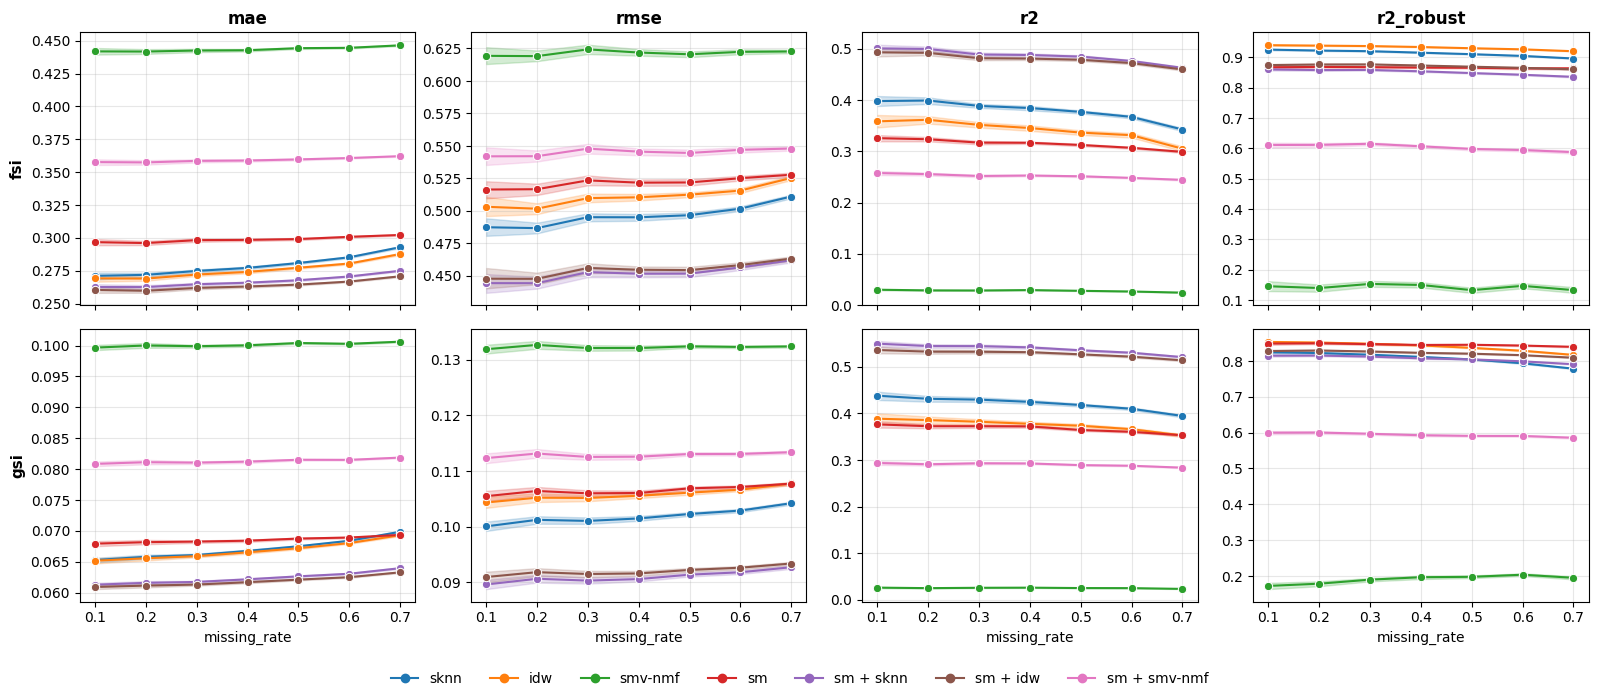

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['mae', 'rmse', 'r2', 'r2_robust']
features = results_df['feature'].unique()
methods = results_df.method.unique()
palette = sns.color_palette("tab10", n_colors=len(methods))

n_rows = len(features)
n_cols = len(metrics)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex='col', sharey=False
)

for i, feature in enumerate(features):
    sub = results_df[results_df['feature'] == feature]
    for j, metric in enumerate(metrics):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        sns.lineplot(
            data=sub,
            x='missing_rate',
            y=metric,
            hue='method',
            marker='o',
            ax=ax,
            palette=palette,
            legend=False 
        )
        if i == 0:
            ax.set_title(metric, fontsize=12, weight='bold')
        if j == 0:
            ax.set_ylabel(feature, fontsize=11, weight='bold')
        else:
            ax.set_ylabel('')
        if i != n_rows - 1:
            ax.set_xlabel('')
        ax.grid(True, alpha=0.3)

handles = [plt.Line2D([0], [0], color=palette[i], marker='o', label=meth) 
           for i, meth in enumerate(methods)]
labels = methods
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
